<a href="https://colab.research.google.com/github/BrightmanMT/Pytorch-Tutorial-Youtube/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid


import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# convert MNIST image files into a tensor 4 dimensions (# of images, Hieght, widht, color channels)

transform = transforms.ToTensor()

In [3]:
#train our data
train_data = datasets.MNIST(root = '/cnn_data', train = True, download = True, transform = transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.36MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.90MB/s]


In [4]:
test_data = datasets.MNIST(root = '/cnn_data', train = False, download = True, transform = transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
#create a small batch size
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [8]:
# Define Our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
# This is just an example will build the actual in the next

conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
# Grab mnist reccord/data
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [10]:
X_Train.shape

torch.Size([1, 28, 28])

In [11]:
x  = X_Train.view(1, 1, 28, 28)

In [12]:
#Perfom first convolution
x = F.relu(conv1(x)) #Rectified Linear Unit for activation function

In [13]:
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
# pass through the pooling layer
x = F.max_pool2d(x, 2, 2) # kernel 2 and a stride of 2

In [15]:
x.shape

torch.Size([1, 6, 13, 13])

In [16]:
# Do scond convulution layer
x = F.relu(conv2(x))

In [17]:
x.shape #we didnt set padding so we lose 2 pixels around the outside of the image

torch.Size([1, 16, 11, 11])

In [18]:
#pooling layer
x = F.max_pool2d(x, 2, 2)

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
# Model Class
class ConvolutionaNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    #fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X= F.relu(self.conv1(X))
    X= F.max_pool2d(X, 2,2) # 2x2 kernel and a stride of 2
    #Second pass
    X= F.relu(self.conv2(X))
    X= F.max_pool2d(X, 2,2)

    #Reveiw to flatten it
    X= X.view(-1, 16*5*5) #-1 so that we can vary the batch size

    #fully connected layers
    X= F.relu(self.fc1(X))
    X= F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim = 1)

In [21]:
# create an instance of our model
torch.manual_seed(41)
model = ConvolutionaNetwork()
model

ConvolutionaNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
#Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # the smaller the learning rate the longer it gonna take to train the model

In [26]:
import time
start_time = time.time()

# create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#For loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  #Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #start our batches at 1
    y_pred = model(X_train) #get predicted values from the training set. Not flattened
    loss = criterion(y_pred, y_train) #how off we? compare the predictions to correct answeres in y_train

    predicted = torch.max(y_pred.data, 1)[1] #add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() #how many we got correct from the batch. True = 1, False =0, sum those up
    trn_corr += batch_corr #keep track as we go along in training

    #update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print out some results
    if b%600 == 0:
      print(f'Epoch:{i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  #Test
  with torch.no_grad(): #no gradient so tht we dont update our weights and biases with test
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] #Adding up correct predictions
      tst_corr+= (predicted == y_test).sum() #T=1 F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()

total = current_time - start_time
print(f'Training took: {total/60} minutes!')

Epoch:0 Batch: 600 Loss: 0.005851339548826218
Epoch:0 Batch: 1200 Loss: 0.3855525553226471
Epoch:0 Batch: 1800 Loss: 0.004819948226213455
Epoch:0 Batch: 2400 Loss: 0.003216963727027178
Epoch:0 Batch: 3000 Loss: 0.0332382395863533
Epoch:0 Batch: 3600 Loss: 0.5372857451438904
Epoch:0 Batch: 4200 Loss: 0.04561494290828705
Epoch:0 Batch: 4800 Loss: 0.0007510822033509612
Epoch:0 Batch: 5400 Loss: 0.0001173773780465126
Epoch:0 Batch: 6000 Loss: 0.14201366901397705
Epoch:1 Batch: 600 Loss: 0.023733172565698624
Epoch:1 Batch: 1200 Loss: 0.003455493599176407
Epoch:1 Batch: 1800 Loss: 0.0008372392621822655
Epoch:1 Batch: 2400 Loss: 0.010705141350626945
Epoch:1 Batch: 3000 Loss: 0.008078320883214474
Epoch:1 Batch: 3600 Loss: 0.0011862406972795725
Epoch:1 Batch: 4200 Loss: 0.038080841302871704
Epoch:1 Batch: 4800 Loss: 0.0016068397089838982
Epoch:1 Batch: 5400 Loss: 0.138673797249794
Epoch:1 Batch: 6000 Loss: 0.2449204921722412
Epoch:2 Batch: 600 Loss: 0.007151054684072733
Epoch:2 Batch: 1200 Loss

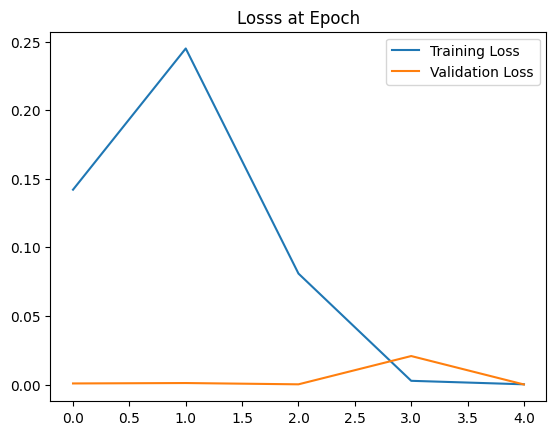

In [28]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Validation Loss')
plt.title("Losss at Epoch")
plt.legend()
plt.show();

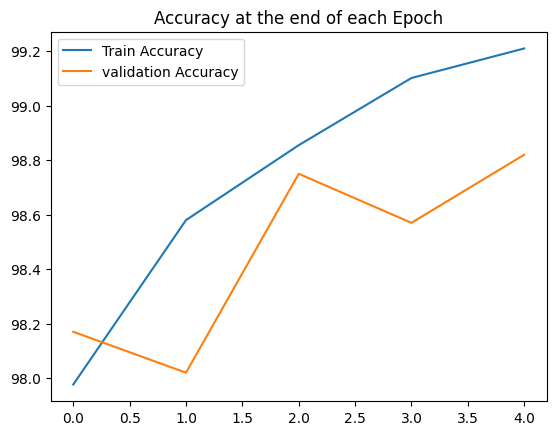

In [29]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = 'Train Accuracy')
plt.plot([t/100 for t in test_correct], label = 'validation Accuracy')
plt.title("Accuracy at the end of each Epoch")
plt.legend();

In [30]:
test_load_everything = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [31]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [32]:
#Did for correct
correct.item()/len(test_data)*100

98.82

In [33]:
# Grab an image
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [34]:
# Grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [36]:
#Reshape it
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

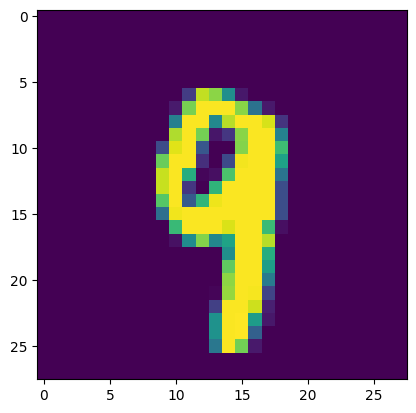

In [37]:
#show the image
plt.imshow(test_data[4143][0].reshape(28,28))

In [38]:
# pass the image through our model
model.eval()
with torch.no_grad():
  new_predictions = model(test_data[4143][0].view(1,1,28,28))

In [39]:
#Check the new predictions... get probability
new_predictions

tensor([[-1.9921e+01, -1.4445e+01, -1.7280e+01, -1.4124e+01, -6.1602e+00,
         -1.4896e+01, -2.8182e+01, -8.4405e+00, -1.2595e+01, -2.3356e-03]])

In [40]:
new_predictions.argmax()

tensor(9)